In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from itertools import cycle
from functools import partial
from glob import glob

sys.path.append('../../hamp_pred/')
from utils.measure import measure_one_HAMP, average_angles, get_ref_crick
from utils.tools import diffangle

# lbs tools package is avaliable at https://github.com/labstructbioinf/lbs-tools
sys.path.append('/home/nfs/sdunin/scr/lbs-tools/')
from lbs.dl.encoders import radius, phobos

# localpdb package is avaliable at https://github.com/labstructbioinf/localpdb
#sys.path.append('/home/nfs/sdunin/scr/')
from localpdb import PDB


/home/users/sdunin/miniconda3/envs/hamppred/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
lpdb = PDB('/home/db/localpdb', plugins=['PDBSeqresMapper'])

In [3]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.filterwarnings(action='ignore', category=PDBConstructionWarning, module='Bio')
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [4]:
data_dir = '../../data/input'

crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

AA_3_to_1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


In [5]:
exp_hamps = [
    
    # HAMP Af1503
    ['2l7h.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT', False], # Af1503 WT
    ['2l7i.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F', False], # Af1503 A291F
    ['2y0q.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', False], # Af1503 A291C
    ['2y20.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', False], # Af1503 A291I
    ['2y21.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', False], # Af1503 A291V
    
    # NarQ
    ['5iji.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', False], # NarQ
    ['5jeq.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', True], # NarQ R50K
    ['5jef.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', True],  
    ['5jgp.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', True],  
        
    # HAMP-DhP
    ['3zrx.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503-DHp', True], 
    ['3zrv.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],
    ['3zrw.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],
    ['3zcc.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],
    ['2lfr.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],  
    ['2lfs.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],
    ['4cti.pdb', 283, 311, 13, 'C', 'D', 'a', 'lightgrey', '', True], 
    
    ['4biv.pdb', 189, 217, 13, 'A', 'B', 'a', 'lightgrey', 'CpxA', False], # CpxA
    ['3zx6.pdb', 7, 35, 13, 'A', 'B', 'a', 'lightgrey', '',    True],  # Hamp(AF1503)-Tsr
    ['4cq4.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', '', True],  # Af1503-sol
    ['4gn0.pdb', 253, 281, 13, 'A', 'C', 'a', 'lightgrey', '', True],  # HAMP + something
    ['4i5s.pdb', 40, 67, 13, 'A', 'B', 'a', 'lightgrey', 'VicK',   False], # VicK
    
    ['3lnr.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_1',  False],  
    ['3lnr.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_2',  False],  
    ['3lnr.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_3',False], 
    
]

exp_hamp2name = {str(n)+"_"+e[0]:e[-2] for n, e in enumerate(exp_hamps)}
exp_hamp2name

{'0_2l7h.pdb': 'Af1503 WT',
 '1_2l7i.pdb': 'Af1503 A291F',
 '2_2y0q.pdb': '',
 '3_2y20.pdb': '',
 '4_2y21.pdb': '',
 '5_5iji.pdb': '',
 '6_5jeq.pdb': '',
 '7_5jef.pdb': '',
 '8_5jgp.pdb': '',
 '9_3zrx.pdb': 'Af1503-DHp',
 '10_3zrv.pdb': '',
 '11_3zrw.pdb': '',
 '12_3zcc.pdb': '',
 '13_2lfr.pdb': '',
 '14_2lfs.pdb': '',
 '15_4cti.pdb': '',
 '16_4biv.pdb': 'CpxA',
 '17_3zx6.pdb': '',
 '18_4cq4.pdb': '',
 '19_4gn0.pdb': '',
 '20_4i5s.pdb': 'VicK',
 '21_3lnr.pdb': 'Aer2_1',
 '22_3lnr.pdb': 'Aer2_2',
 '23_3lnr.pdb': 'Aer2_3'}

### Prepare AF2 jobs for the experimental structures

In [6]:
ok_sequences = []

# files available upon request
af2_path = '/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15' # 5 recycles / ColabFold 1.5
EXTENSION = 3 # how many aa to add at the N/C ends
helices = []

for pos, row in enumerate(exp_hamps):
    pdb, pdb_startN, pdb_startC, length, chain_A, chain_B, heptad, color, name, mutant = row
    pdb = pdb.split('.')[0]
        
    # get HAMP sequence with the linker 
    pdb_chain = f'{pdb.lower()}_{chain_A.upper()}'
    chain_seq = lpdb.chains.loc[pdb_chain].sequence
    chain_mapping = lpdb.get_pdbseqres_mapping(pdb_chain)
    inv_chain_mapping = {v: k for k, v in chain_mapping.items()}
    
    seq_startN = chain_mapping[str(pdb_startN)]
    seq_startC = chain_mapping[str(pdb_startC)]
    
    n_helix = chain_seq[seq_startN:seq_startN+length]
    c_helix = chain_seq[seq_startC:seq_startC+length]
    
    if not mutant:
        full_seq = n_helix + c_helix
        assert full_seq not in ok_sequences, pdb
        ok_sequences.append(full_seq)
    
    print ('\t'.join([pdb, n_helix, c_helix]))
    
    # debug
    # pdb, seq_startN, n_helix, seq_startN+len-1, seq_startC
    #if row[-1] == False:
    #    print(inv_chain_mapping[seq_startC+length-1])
        
    full_seq = chain_seq[seq_startN-EXTENSION:seq_startC+length+EXTENSION]
    
    helices.append([n_helix, c_helix, full_seq])
    
    # create job's path
    path = os.path.join(af2_path, f'{pos}_{pdb}')
    try:
        os.makedirs(path)
    except FileExistsError:
        continue
    
    # write slurm config
    txt='''#!/bin/bash
#SBATCH -p gpu
#SBATCH -n 1
#SBATCH --exclude=edi00
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH -J HAMP
source /opt/miniconda3/bin/activate cf_1.5
export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
colabfold_batch query.csv . --num-recycle 5'''
    
    f = open(os.path.join(path, 'job.sh'), 'wt')
    f.write(txt)
    f.close()
    
    # write colabfold input
    txt = f'''id,sequence
model,{full_seq}:{full_seq}'''
    
    f = open(os.path.join(path, 'query.csv'), 'wt')
    f.write(txt)
    f.close()    
    
        

2l7h	PIIELSNTADKIA	EIGILAKSIERLR
2l7i	PIIELSNTFDKIA	EIGILAKSIERLR
2y0q	PIIELSNTCDKIA	EIGILAKSIERLR
2y20	PIIELSNTIDKIA	EIGILAKSIERLR
2y21	PIIELSNTVDKIA	EIGILAKSIERLR
5iji	PLNQLVTASQRIE	ELGLLAKTFNQMS
5jeq	PLNQLVTASQRIE	ELGLLAKTFNQMS
5jef	PLNQLVTASQRIE	ELGLLAKTFNQMS
5jgp	PLNQLVTASQRIE	ELGLLAKTFNQMS
3zrx	PIIELSNTFDKIA	EIGILAKSIERLR
3zrv	PIIELSNTFDKIA	EIGILAKSIERLR
3zrw	PIIELSNTVDKIA	EIGILAKSIERLR
3zcc	PIIELSNTADKIA	EIGILAKSIERLR
2lfr	PIIELSNTADKIA	EIGILAKSIERLR
2lfs	PIIELSNTFDKIA	EIGILAKSIERLR
4cti	PIIELSNTFDKIA	EIGILAKSIERLR
4biv	PARKLKNAADEVA	EFLAAGASFNQMV
3zx6	PIIELSNTVDKIA	EIGILAKSIERLR
4cq4	PIIELSNTADKIA	EIGILAKSIERLR
4gn0	PIIELSNTADKIA	EIGILAKSIERLR
4i5s	QVKQLNAKVRSLI	DLSELVNNVNDLS
3lnr	RADRIATLLQSFA	GYERLYDSLRALQ
3lnr	LEAGLAEMSRQHE	RAARIAKGVNELV
3lnr	VKMKVVSVVTAYG	KKAQITEAIDGVR


### Measure AF2 models of the experimental structures
Models are unrelaxed

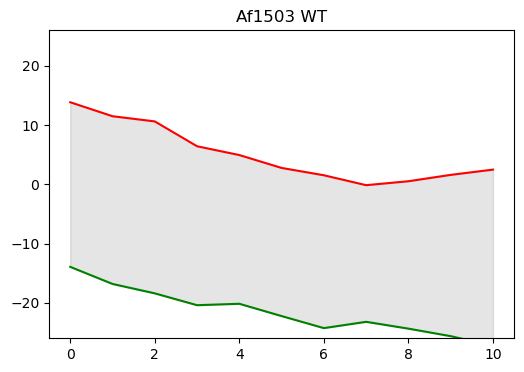

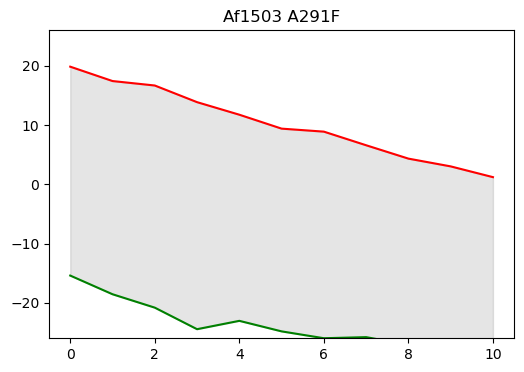

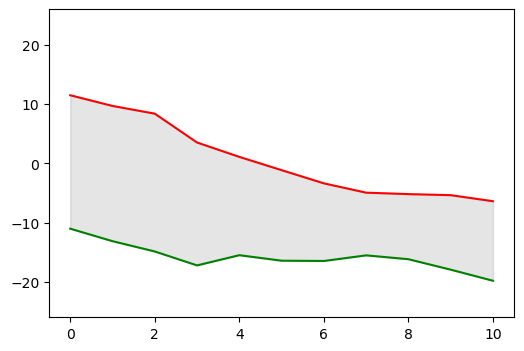

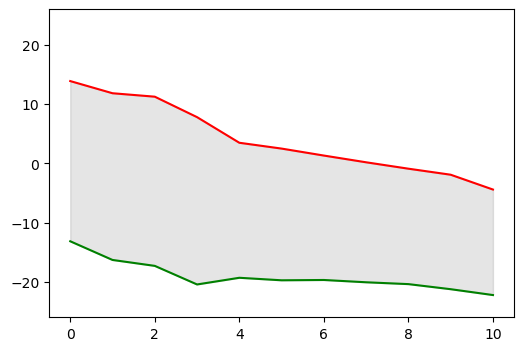

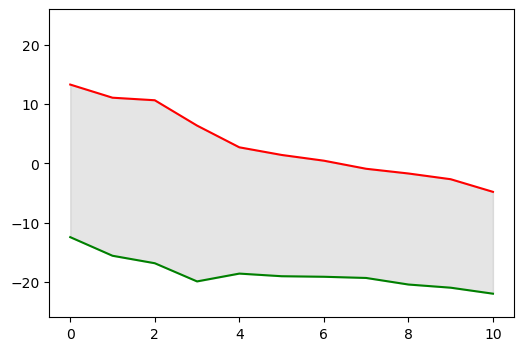

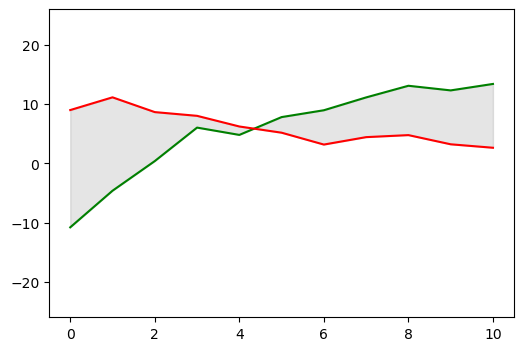

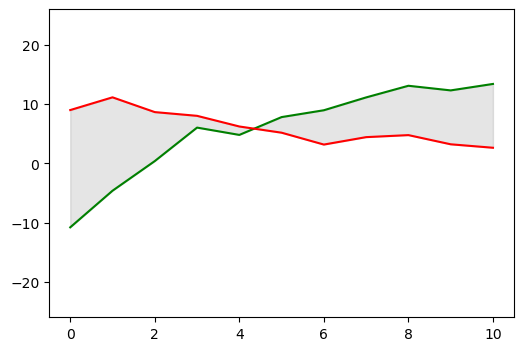

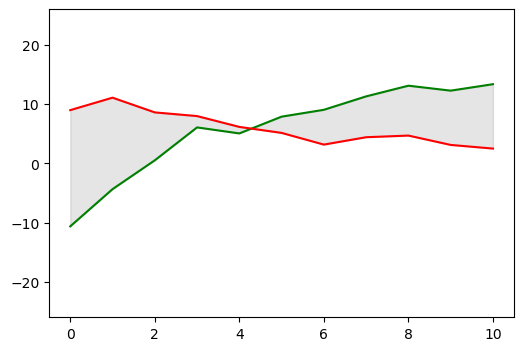

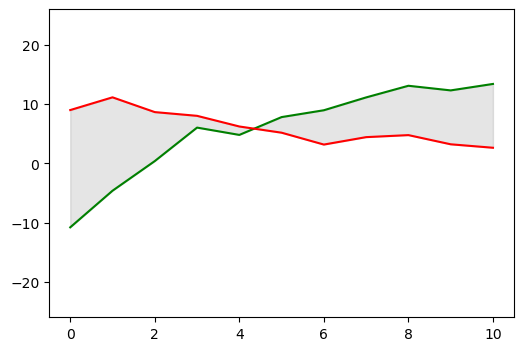

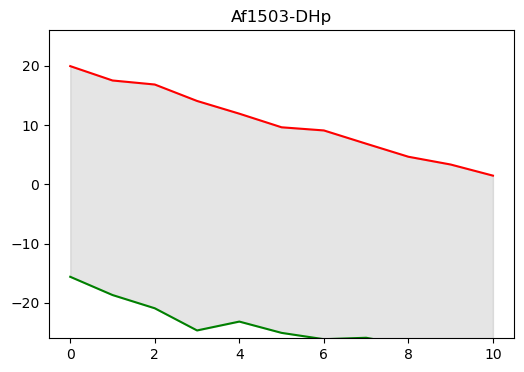

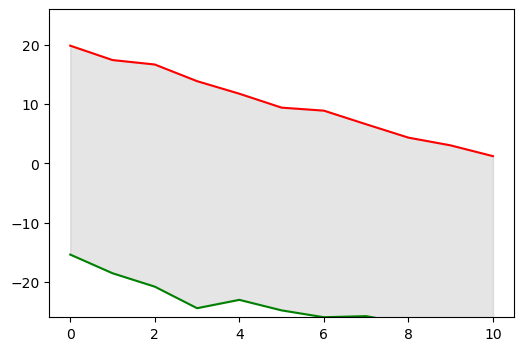

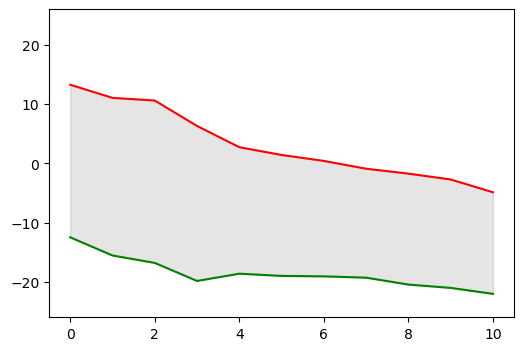

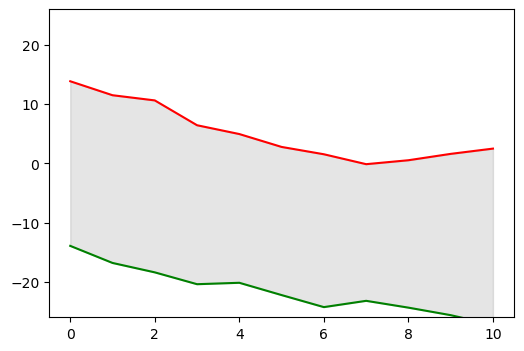

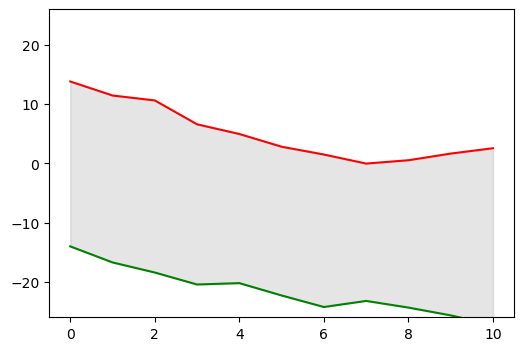

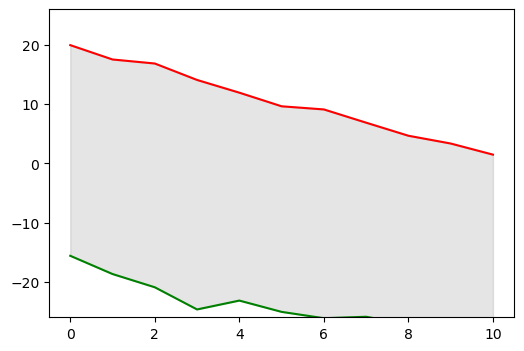

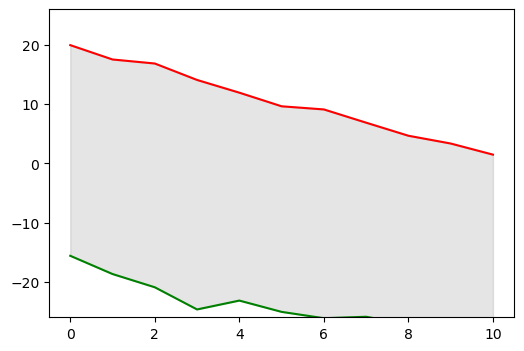

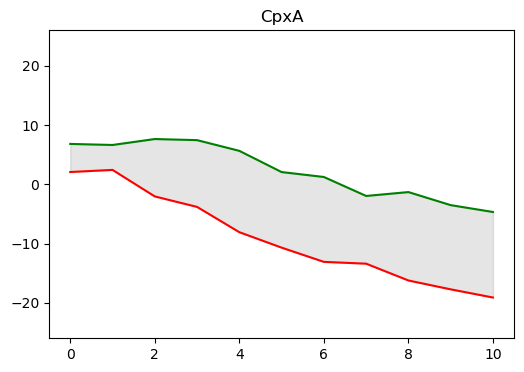

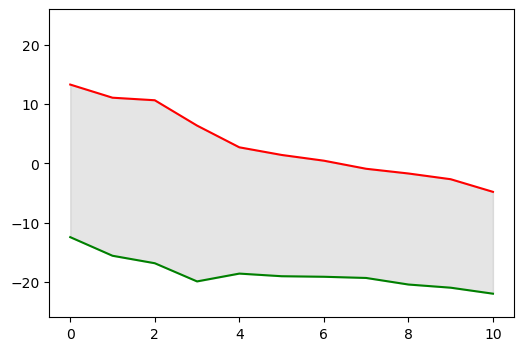

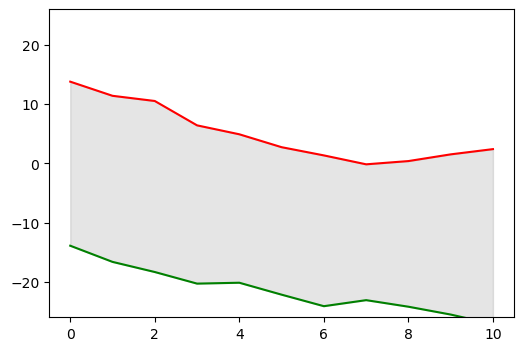

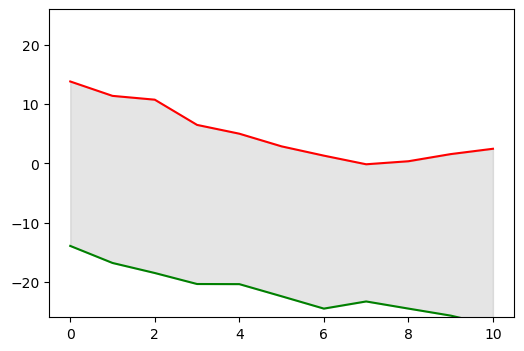

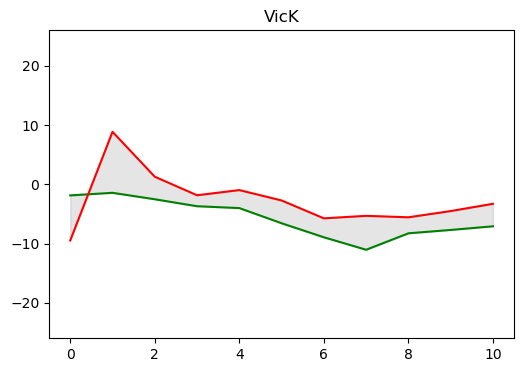

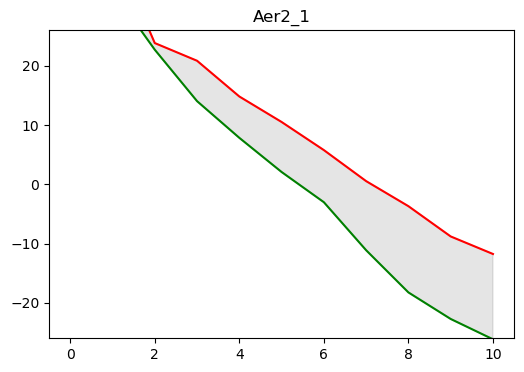

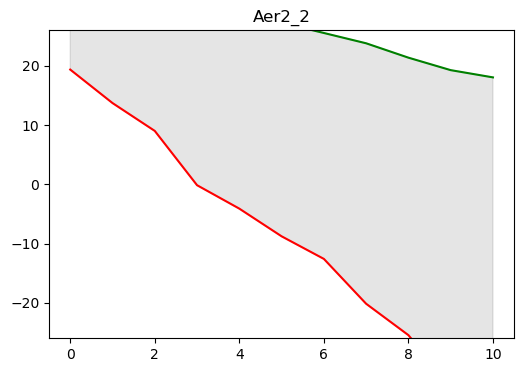

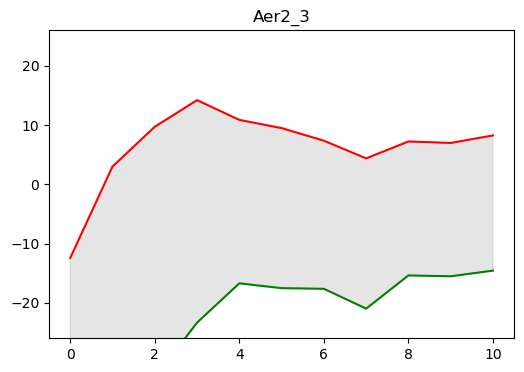

In [7]:
data=[]

for pos, (exp_hamp, helix) in enumerate(zip(exp_hamps, helices)):
    
    pdb = exp_hamp[0].split('.')[0]
    n_helix_seq = helix[0]
    c_helix_seq = helix[1]
    full_seq = helix[2]
    name = exp_hamp[-2]
    
    assert full_seq.find(n_helix_seq) == EXTENSION
    
    # get pdb ranges        
    h1_start = EXTENSION
    h2_start = full_seq.find(c_helix_seq)
    
    a1_start, a1_stop = h1_start+1, h1_start+len(n_helix_seq)+1
    a2_start, a2_stop = h2_start+1, h2_start+len(c_helix_seq)+1
    chain1, chain2 = 'A', 'B'
    
    kwargs = {'a1_start':a1_start, 
              'a1_stop':a1_stop,
              'a2_start':a2_start,
              'a2_stop':a2_stop,
              'chain1':chain1,
              'chain2':chain2}
    
    # get 1 rank af2 model
    path = os.path.join(af2_path, f'{pos}_{pdb}')
    
    pdb_files = sorted(
        glob(os.path.join(path, '*_unrelaxed*.pdb')), 
        key=lambda x:int(x.split('/')[-1].split("_")[3])
    )
    
    assert len(pdb_files)>0, 'Missing models'
    pdb_file = pdb_files[0]
    
    # measure
    bundle_df, n_crick, c_crick = measure_one_HAMP(pdb_file,
                                                 a1_start, a1_stop,
                                                 a2_start, a2_stop,
                                                 chain1, chain2)

    n_crick = n_crick[2:-2]
    c_crick = c_crick[2:-2]
    
    P = bundle_df.P.values
    n_P_list = P[0::2][2:-2]
    c_P_list = P[1::2][2:-2]
        
    r = bundle_df.P.values
    n_r_list = r[0::2][2:-2]
    c_r_list = r[1::2][2:-2]
        
    n_P = c_P = 3.5
     
    c_phi = n_phi = crangles[exp_hamp[6]] 
    
    n_crick_ref = get_ref_crick(n_P, n_phi)[:len(n_crick)]
    c_crick_ref = get_ref_crick(c_P, c_phi)[:len(c_crick)]
        
    n_crick_diff = diffangle(n_crick, n_crick_ref)
    n_crick_diff = (n_crick_diff[0::2] + n_crick_diff[1::2])/2
    
    c_crick_diff = diffangle(c_crick, c_crick_ref)
    c_crick_diff = (c_crick_diff[0::2] + c_crick_diff[1::2])/2
    
    rot = diffangle(n_crick, c_crick) / 2
    rot = (rot[0::2] + rot[1::2])/2
    
    #print(exp_hamp[0], rot.mean())
    
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.plot(n_crick_diff, label=exp_hamp[0]+"_N", color='green')
    ax.plot(c_crick_diff, label=exp_hamp[0]+"_C", color='red')
    
    ax.fill_between(range(len(n_crick_diff)), n_crick_diff, c_crick_diff,
                   color='k', alpha=0.1)
    
    #ax.plot(rot, label=exp_hamp[0]+"rotation", color='black')
    ax.set_ylim(-26, 26)
    ax.set_title(name)
        
    n_crick_diff = np.mean(n_crick_diff)
    c_crick_diff = np.mean(c_crick_diff)
            
    seq1 = bundle_df.res_name[0::4].tolist()
    seq2 = bundle_df.res_name[1::4].tolist()
    seq1 = "".join([AA_3_to_1[res] for res in seq1])
    seq2 = "".join([AA_3_to_1[res] for res in seq2])
    
    assert seq1 == n_helix_seq
    assert seq2 == c_helix_seq
    
    data.append([str(pos)+ "_" + exp_hamp[0], n_crick_diff, c_crick_diff, seq1, seq2, exp_hamp[7], n_crick, c_crick, exp_hamp[8],
                exp_hamp[9]])
    
    
data_af2_df = pd.DataFrame(data, columns=['pdb', 'n_rot', 'c_rot', 'seq1', 'seq2', 'color', 'n_list', 'c_list', 'label', 'mutant'])
data_af2_df.set_index('pdb', inplace=True)

data_af2_df['rot'] = diffangle(data_af2_df.n_list, data_af2_df.c_list) 
data_af2_df['rot_mean'] = data_af2_df['rot'].apply(np.mean)
data_af2_df['rot_std'] = data_af2_df['rot'].apply(np.std)

data_af2_df.to_pickle(os.path.join(data_dir, 'pdb_af2_measure.p'))


In [8]:
len(data_af2_df)

24

### Measure experimental structures

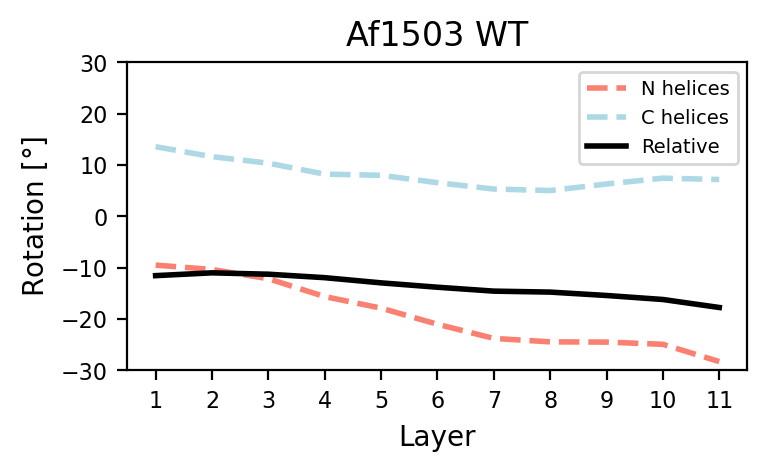

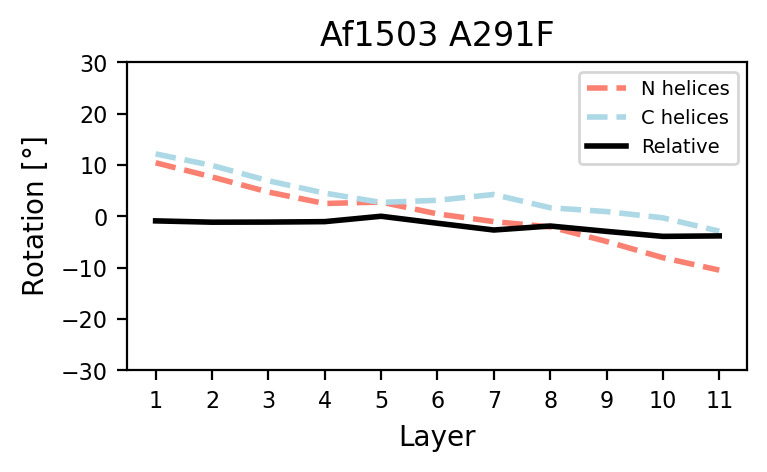

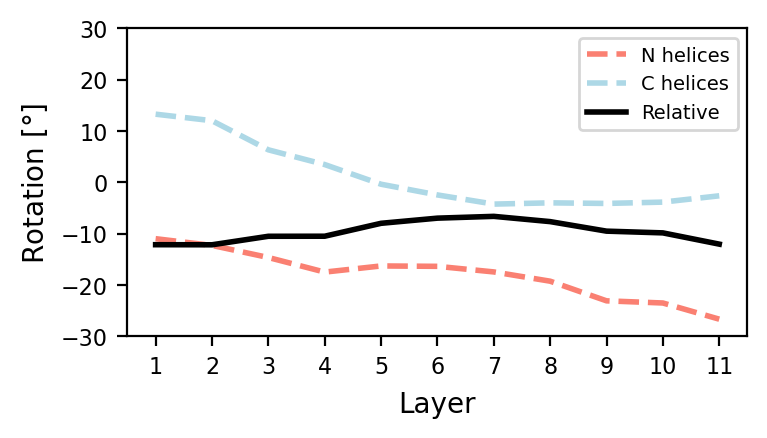

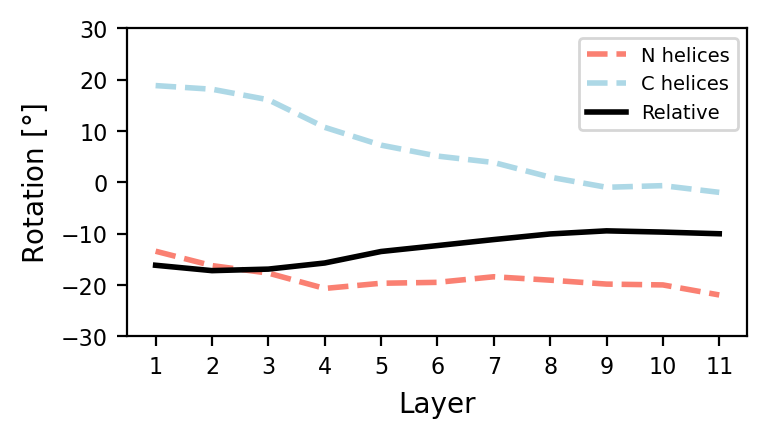

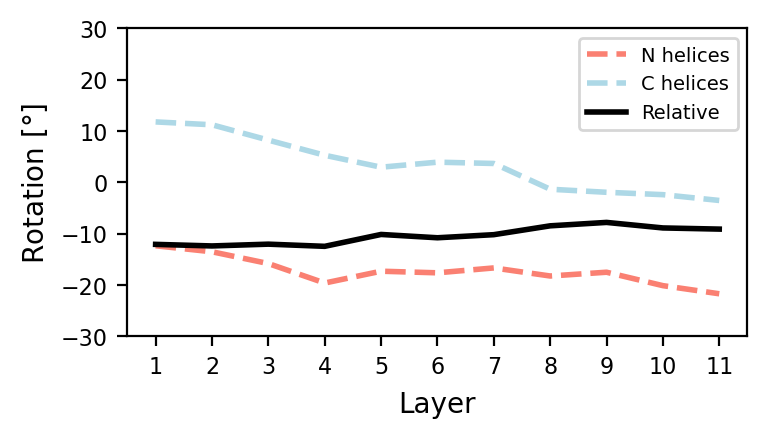

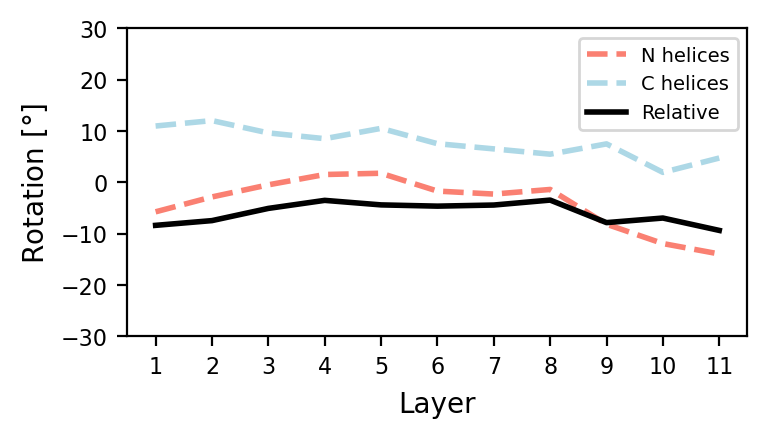

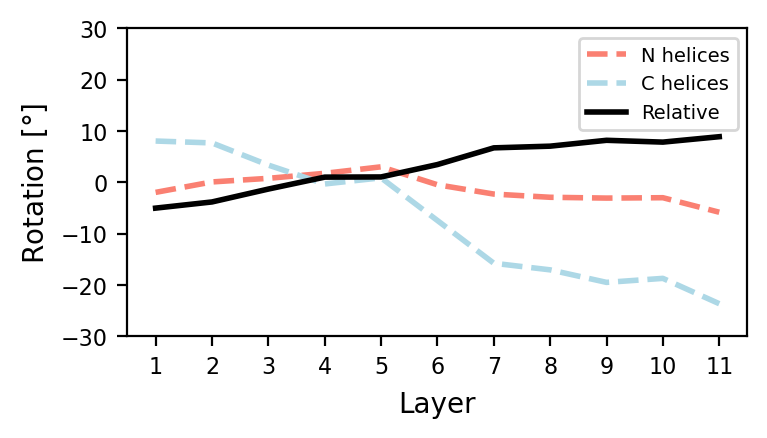

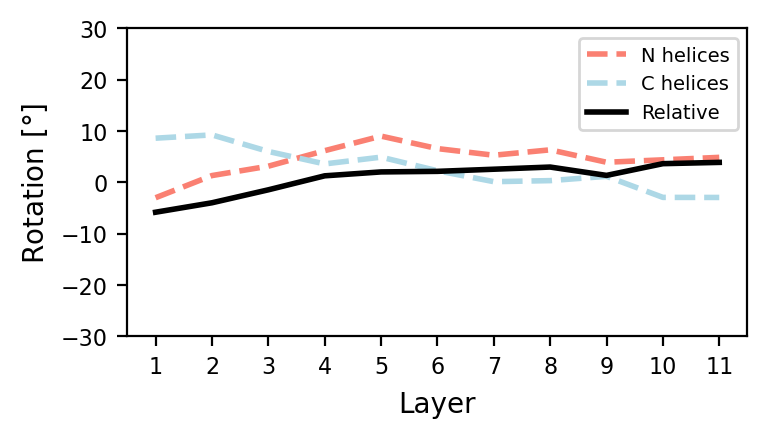

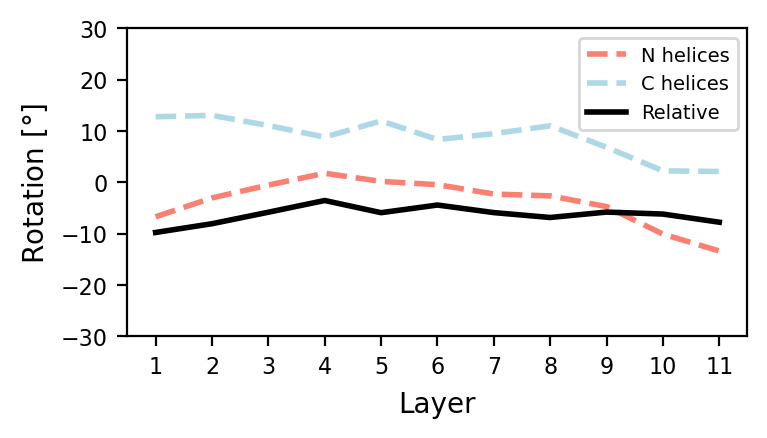

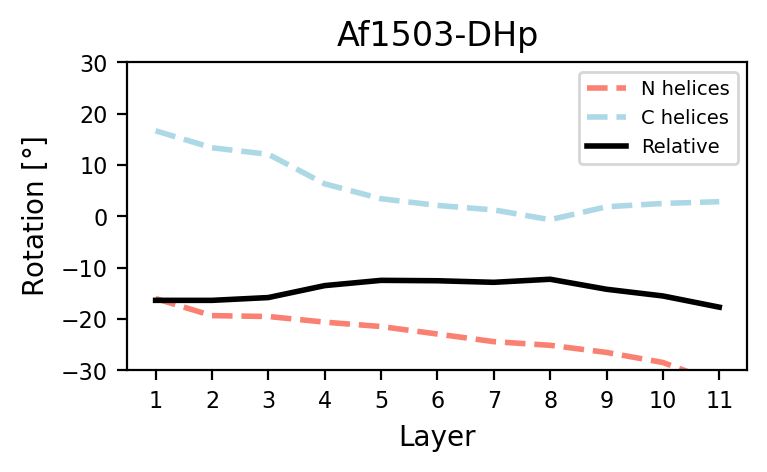

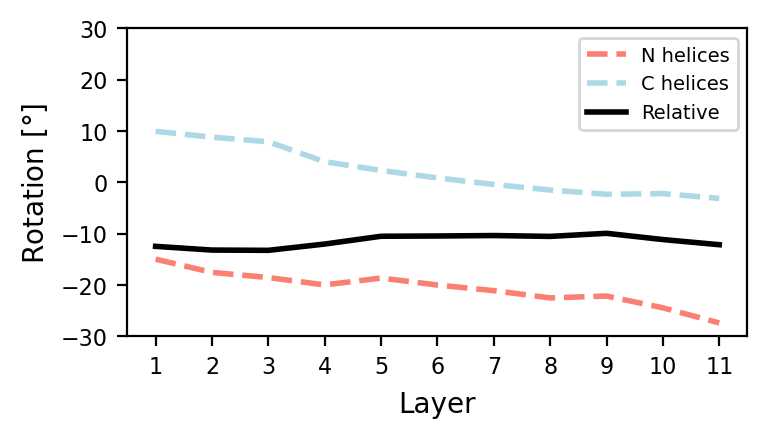

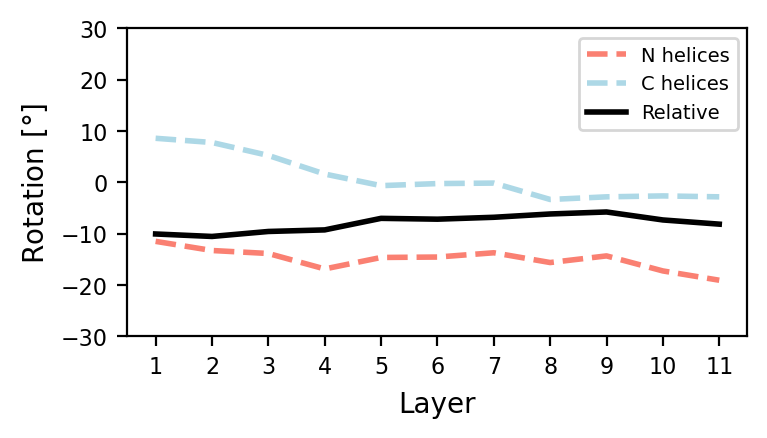

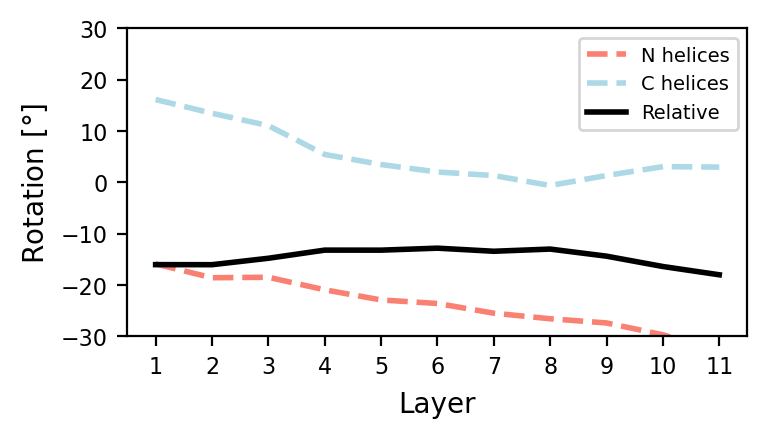

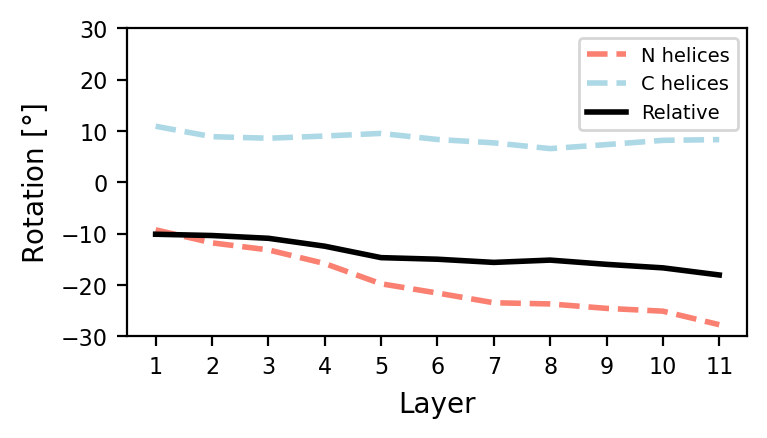

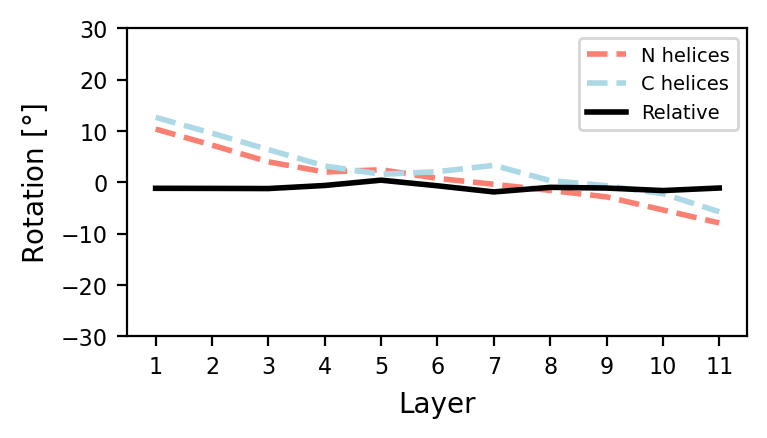

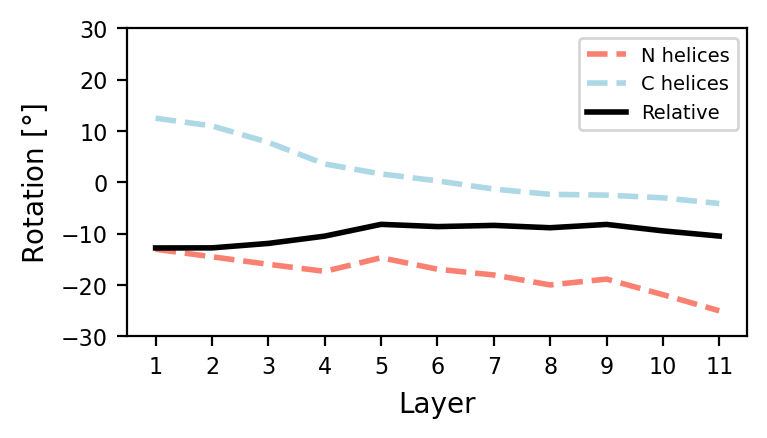

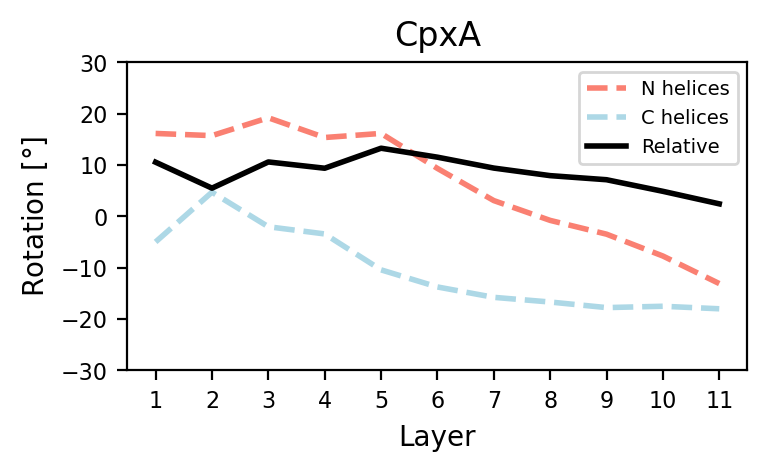

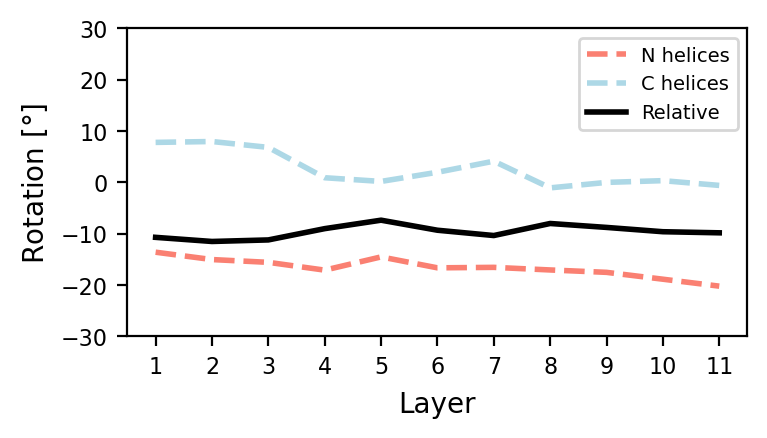

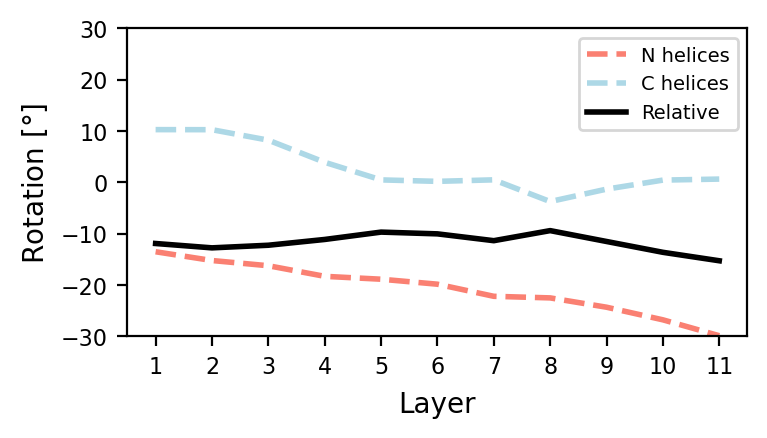

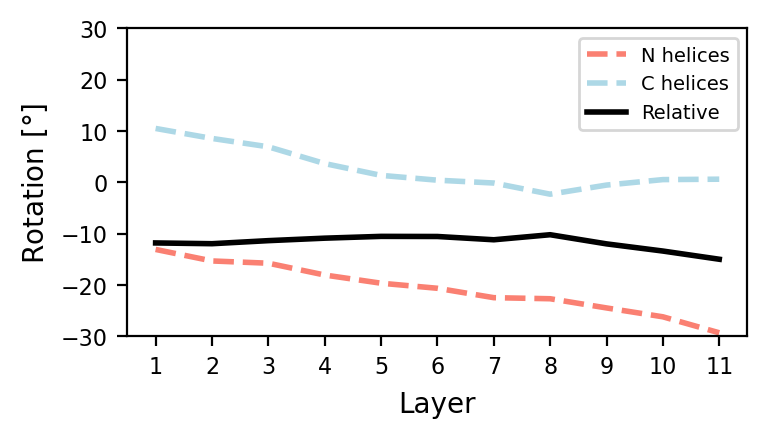

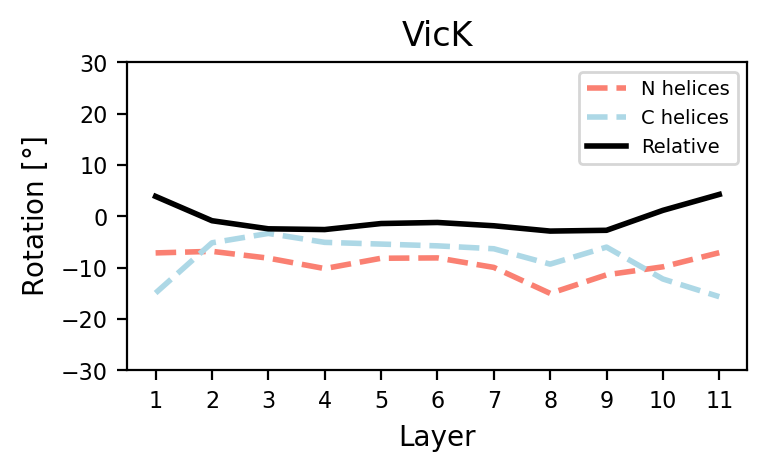

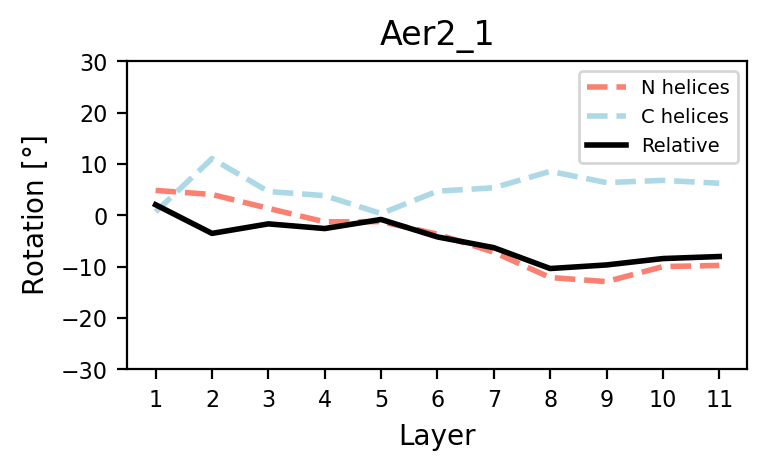

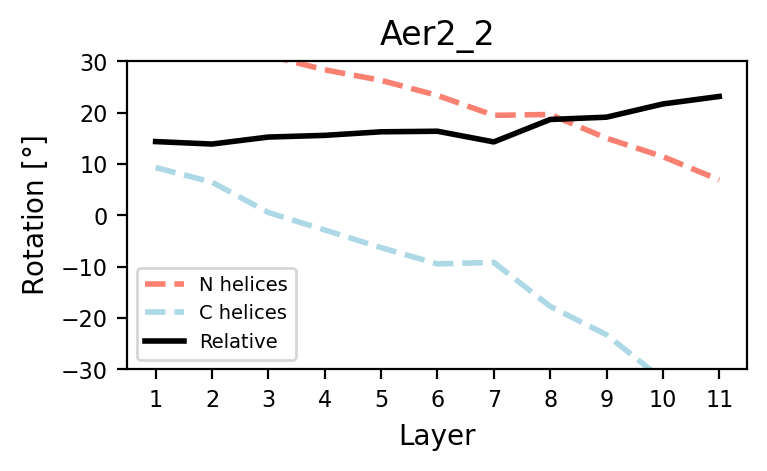

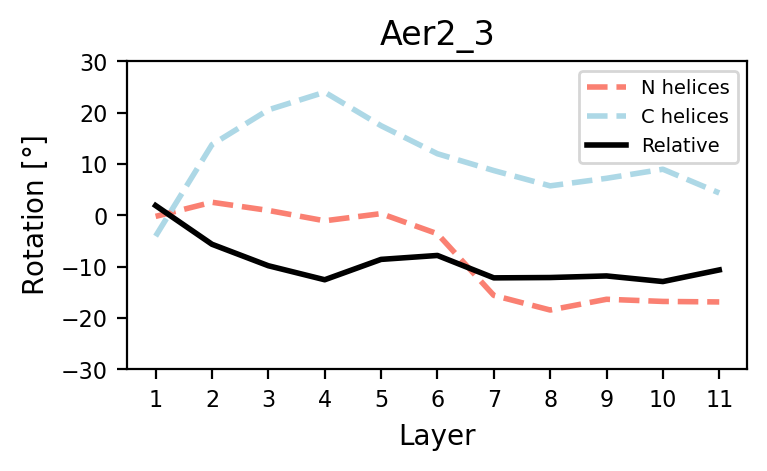

In [9]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

data=[]

for pos, exp_hamp in enumerate(exp_hamps):
    pdb_file = os.path.join(data_dir, 'struct_in', exp_hamp[0])
    
    # define measurment ranges
    
    a1_start = exp_hamp[1]
    a1_stop = a1_start + exp_hamp[3]
    a2_start = exp_hamp[2]
    a2_stop = a2_start + exp_hamp[3] 
    
    chain1 = exp_hamp[4]
    chain2 = exp_hamp[5]
    
    bundle_df, n_crick, c_crick = measure_one_HAMP(pdb_file,
                                                 a1_start, a1_stop,
                                                 a2_start, a2_stop,
                                                 chain1, chain2)

    n_crick = n_crick[2:-2]
    c_crick = c_crick[2:-2]
    
    P = bundle_df.P.values
    n_P_list = P[0::2][2:-2]
    c_P_list = P[1::2][2:-2]
        
    r = bundle_df.P.values
    n_r_list = r[0::2][2:-2]
    c_r_list = r[1::2][2:-2]
        
    n_P = c_P = 3.5
     
    c_phi = n_phi = crangles[exp_hamp[6]] 
    
    n_crick_ref = get_ref_crick(n_P, n_phi)[:len(n_crick)]
    c_crick_ref = get_ref_crick(c_P, c_phi)[:len(c_crick)]
        
    n_crick_diff = diffangle(n_crick, n_crick_ref)
    n_crick_diff = (n_crick_diff[0::2] + n_crick_diff[1::2])/2
    
    c_crick_diff = diffangle(c_crick, c_crick_ref)
    c_crick_diff = (c_crick_diff[0::2] + c_crick_diff[1::2])/2
    
    rot = diffangle(n_crick, c_crick) / 2
    rot = (rot[0::2] + rot[1::2])/2
    
    # plot
    fig, ax = plt.subplots(1,1, figsize=(4, 2), dpi=200)
    
    ax.set_xticks(range(len(n_crick_diff)),
                 labels = [str(i+1) for i in range(len(n_crick_diff))])
    
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    
    ax.plot(n_crick_diff, label="N helices", lw=2, c='salmon', ls='--')
    ax.plot(c_crick_diff, label="C helices", lw=2, c='lightblue', ls='--')
    ax.plot(rot, label="Relative", lw=2, c='k')
        
    ax.set_ylim(-30, 30)
    ax.set_title(exp_hamp[-2], size=title_font_size)
    
    ax.set_xlabel(r'Layer', size=label_font_size)
    ax.set_ylabel(r'Rotation [$\degree$]', size=label_font_size)  
    
    ax.legend(prop={'size': 7})
        
        
    # store a new row
        
    n_crick_diff = np.mean(n_crick_diff)
    c_crick_diff = np.mean(c_crick_diff)
            
    seq1 = bundle_df.res_name[0::4].tolist()
    seq2 = bundle_df.res_name[1::4].tolist()
    seq1 = "".join([AA_3_to_1[res] for res in seq1])
    seq2 = "".join([AA_3_to_1[res] for res in seq2])
    
    data.append([str(pos)+"_"+exp_hamp[0], n_crick_diff, c_crick_diff, seq1, seq2, exp_hamp[7], n_crick, c_crick, exp_hamp[8],
                exp_hamp[9]])
    
    #break
    
    
data_df = pd.DataFrame(data, columns=['pdb', 'n_rot', 'c_rot', 'seq1', 'seq2', 'color', 'n_list', 'c_list', 'label', 'mutant'])
data_df.set_index('pdb', inplace=True)

data_df['rot'] = diffangle(data_df.n_list, data_df.c_list) 
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)

data_df.to_pickle(os.path.join(data_dir, 'pdb_measure.p'))


### Compare experimental structures to AF2 models

In [11]:
assert all(data_af2_df.rot.apply(len) == data_df.rot.apply(len))

In [12]:
def get_labels(df):
    a = np.vstack(df['rot'].values)
    return ((a[:,0::2] + a[:,1::2]) / 2).mean(axis=1) / 2

In [13]:
#     fig, ax = plt.subplots(1,1, figsize=(4, 2), dpi=200)
    
#     ax.set_xticks(range(len(n_crick_diff)),
#                  labels = [str(i+1) for i in range(len(n_crick_diff))])
    
#     ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
#     ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    
#     ax.plot(n_crick_diff, label=exp_hamp[0]+"_N", color='green', lw=2)
#     ax.plot(c_crick_diff, label=exp_hamp[0]+"_C", color='red', lw=2)
    
#     #ax.fill_between(range(len(n_crick_diff)), n_crick_diff, c_crick_diff,
#     #               color='k', alpha=0.1)
    
#     ax.set_ylim(-30, 30)
#     ax.set_title(exp_hamp[-2], size=title_font_size)

Text(0.5, 1.0, 'AlphaFold2')

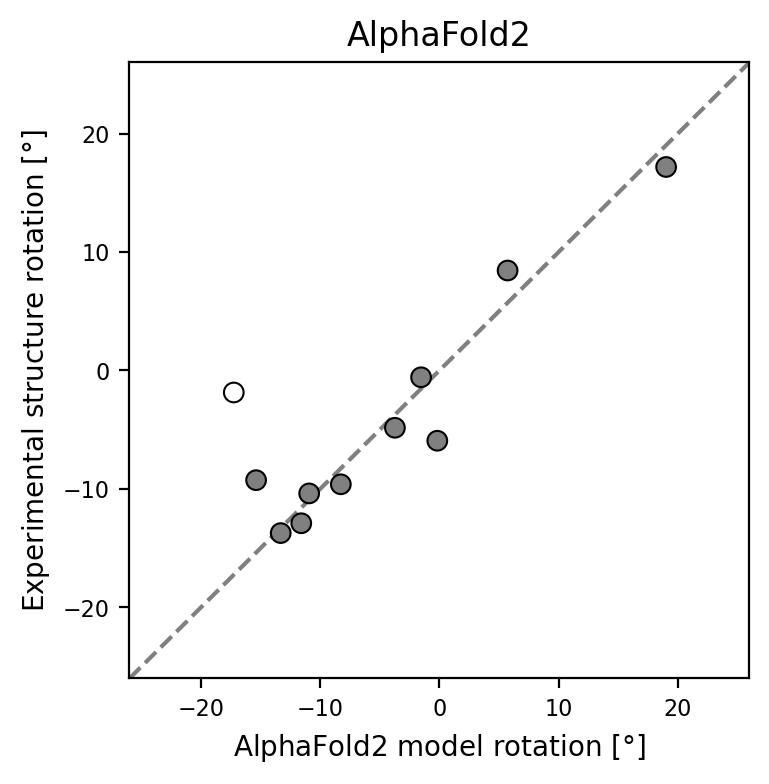

In [14]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

rot_af2 = get_labels(data_af2_df[~data_af2_df.mutant])
rot_pdb = get_labels(data_df[~data_df.mutant])

colors = ['white' if i>8 else 'grey' for i in np.abs(rot_af2 - rot_pdb)]

ax.scatter(rot_af2, rot_pdb, c=colors, lw=0.75, edgecolors='k', s=50)    

ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
ax.set_xlabel(r'AlphaFold2 model rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)
ax.set_title("AlphaFold2", size=title_font_size)


In [15]:
for pdb, rot_af2, rot_pdb in zip(data_df[~data_df.mutant].index, get_labels(data_af2_df[~data_af2_df.mutant]),
                                 get_labels(data_df[~data_df.mutant])):
    print(pdb, rot_af2, rot_pdb, rot_pdb-rot_af2)

0_2l7h.pdb -13.310891624859755 -13.729657206902761 -0.4187655820430063
1_2l7i.pdb -17.247734039422305 -1.8607372293692377 15.386996810053066
2_2y0q.pdb -8.269902623913026 -9.610822024574562 -1.3409194006615355
3_2y20.pdb -11.587862515541769 -12.8995071804536 -1.3116446649118316
4_2y21.pdb -10.925100052280914 -10.379402146855085 0.5456979054258291
5_5iji.pdb -0.17753835823884276 -5.93366519409748 -5.7561268358586375
16_4biv.pdb 5.716154334367343 8.435929964713885 2.7197756303465423
20_4i5s.pdb -1.539174540032706 -0.5763475143583211 0.9628270256743848
21_3lnr.pdb -3.73344966448615 -4.839393724703277 -1.1059440602171273
22_3lnr.pdb 19.01279962518695 17.174883371419803 -1.8379162537671476
23_3lnr.pdb -15.37616400986194 -9.26363300507309 6.112531004788849


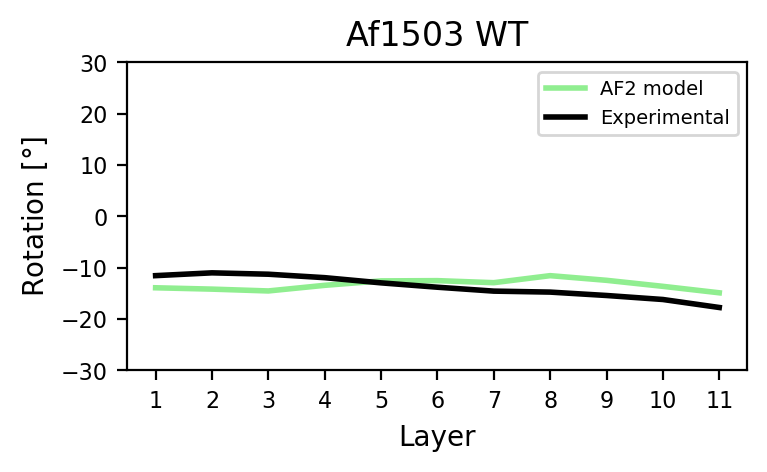

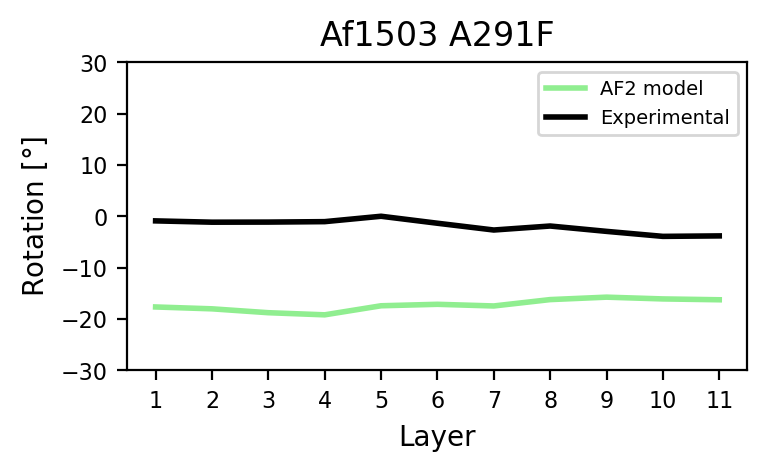

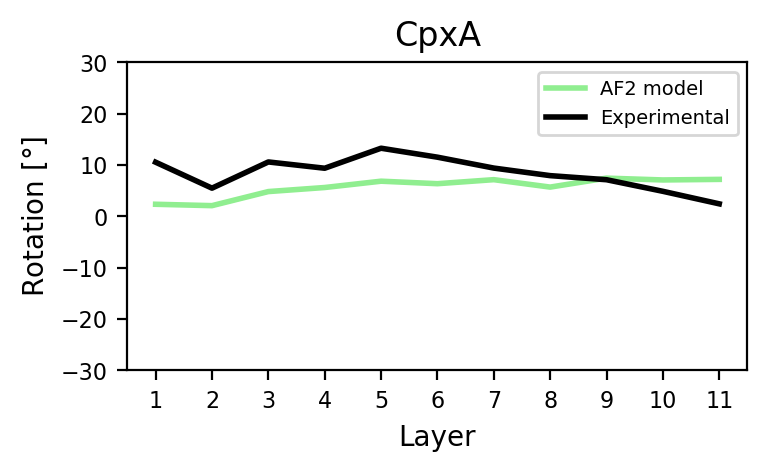

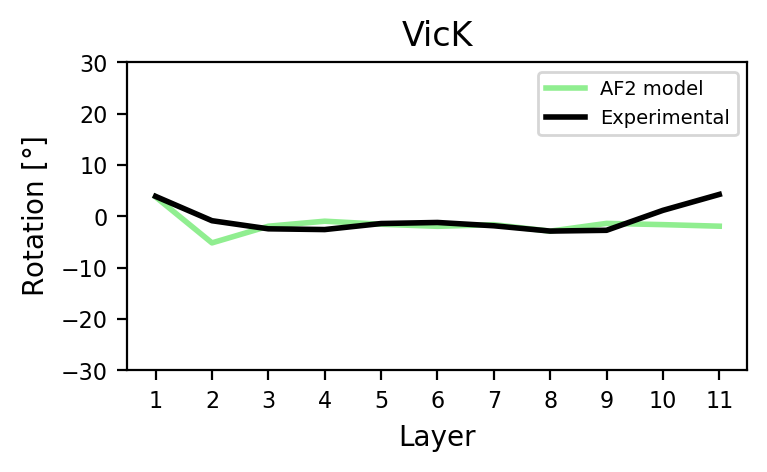

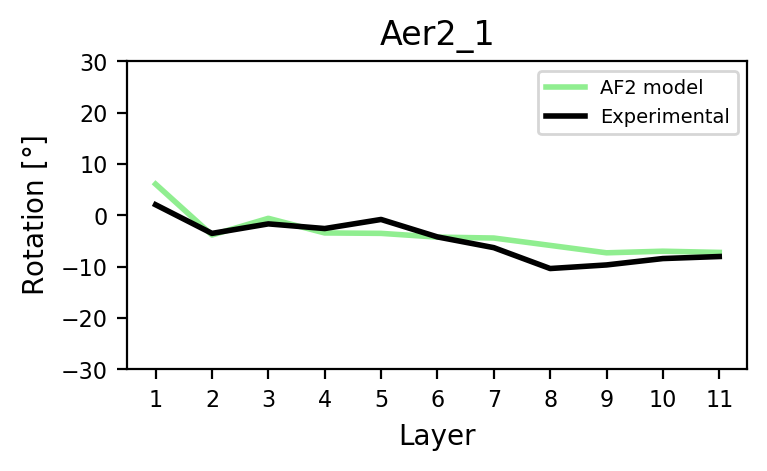

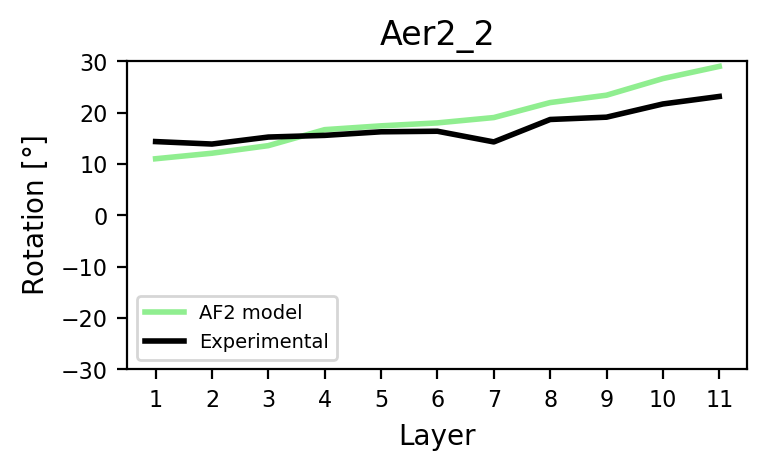

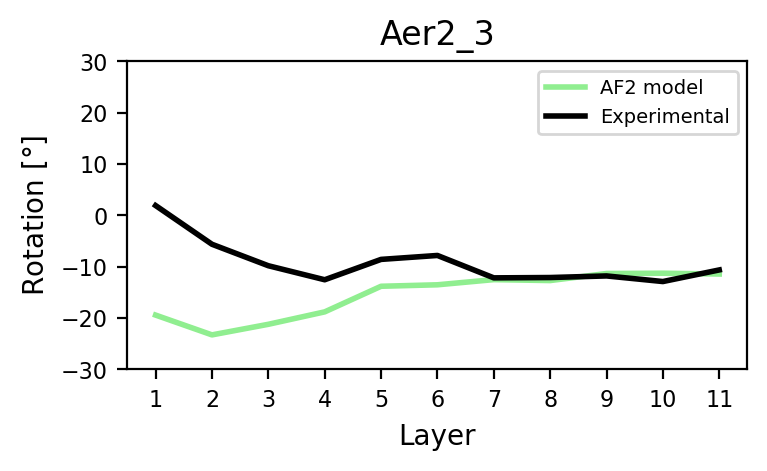

In [18]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

for pos, (pdb, af2_row) in enumerate(data_af2_df.iterrows()):
    
    #ident = str(pos)+"_"+pdb
    ident = pdb
    # no included
    if af2_row.mutant: continue
    
    # no description
    if exp_hamp2name[ident]=="": continue
                
    af2_rot = (af2_row.rot[0::2] + af2_row.rot[1::2])/4
    pdb_row = data_df.loc[ident]   
    pdb_rot = (pdb_row.rot[0::2] + pdb_row.rot[1::2])/4

    # plot
    fig, ax = plt.subplots(1,1, figsize=(4, 2), dpi=200)

    ax.set_xticks(range(len(pdb_rot)),
                 labels = [str(i+1) for i in range(len(pdb_rot))])
    
    ax.set_ylim(-30, 30)
    
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    
    ax.plot(af2_rot, lw=2, label='AF2 model', c='lightgreen')
    ax.plot(pdb_rot, lw=2, label='Experimental', c='k')
    
    ax.set_xlabel(r'Layer', size=label_font_size)
    ax.set_ylabel(r'Rotation [$\degree$]', size=label_font_size)
        
    ax.set_title(exp_hamp2name[ident], size=title_font_size)
    
    ax.legend(prop={'size': 7})
    
    